In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import xarray as xr

from beamforming import Beamformer, SlidingBeamformer, polar_grid

## Data generation

In [19]:
# Parameters
nch = 100  # number of receivers
fs = 100.0  # sampling rate
nt = 512  # number of samples

t = (np.arange(nt) - nt // 2) / fs

# Generate receiver locations
L = 1000  # length of the cable
d = L / nch
s = d / 2 + d * np.arange(nch)

a = L / 3
h = a * np.sqrt(3) / 2
sp = a * np.arange(4)
xp = [-a / 2, a / 2, 0, -a / 2]
yp = [-h / 3, -h / 3, 2 * h / 3, -h / 3]
x = np.interp(s, sp, xp)
y = np.interp(s, sp, yp)
coords = xr.Dataset(
    {
        "x": ("station", x),
        "y": ("station", y),
    }
)

# Generate random data
np.random.seed(42)
data = np.random.randn(nch, nt)
for idx in range(nch):
    delta = x[idx] / 2000.0
    data[idx] += 2.0 * scipy.signal.gausspulse(t + delta, fc=10.0, bw=0.1)
da = xr.DataArray(data, {"time": t}, dims=("station", "time"))


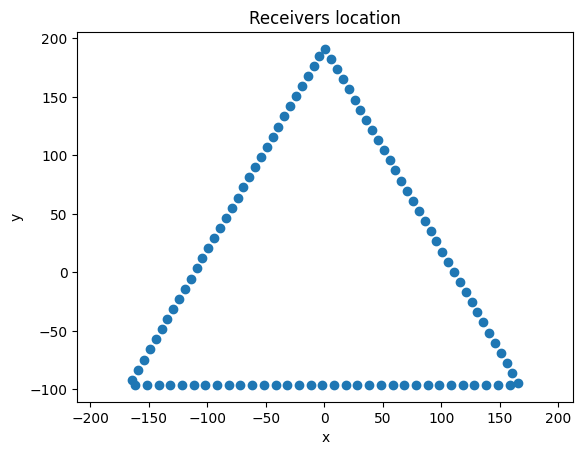

In [20]:
plt.scatter(x, y)
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Receivers location");

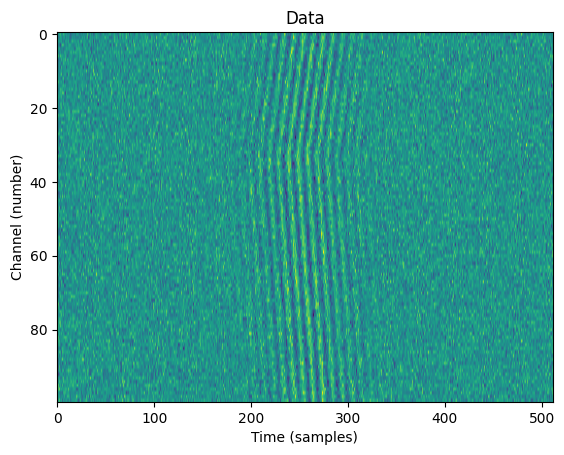

In [21]:
plt.imshow(data, aspect="auto")
plt.xlabel("Time (samples)")
plt.ylabel("Channel (number)")
plt.title("Data");

##  Beamform

In [22]:
theta = np.linspace(0, 2*np.pi, 91)
speed = np.linspace(1e-15, 5_000, 31)
grid = polar_grid(theta, speed)
beamformer = Beamformer(
    coords=coords,
    grid=grid,
    sampling_rate=fs,
    frequency_band=(5.0, 15.0),
    adaptative=True,
    n_tapers=3,
    n_sources=1,
)

In [23]:
P = beamformer.beamform(da)

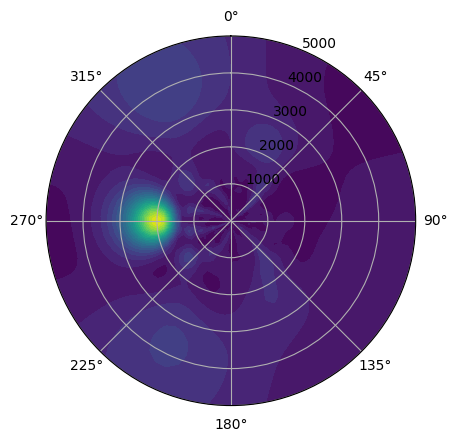

In [24]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.contourf(theta, speed, P.T, cmap="viridis", levels=25)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

## Sliding Beamform

In [25]:
theta = np.linspace(0, 2*np.pi, 91)
speed = np.linspace(1e-15, 5_000, 31)
grid = polar_grid(theta, speed)
beamformer = SlidingBeamformer(
    coords=coords,
    grid=grid,
    frequency_band=(5.0, 15.0),
    nperseg=32,
)

In [26]:
P = beamformer.beamform(da)

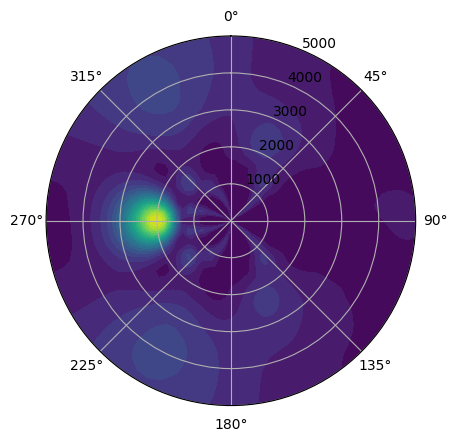

In [27]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.contourf(theta, speed, P.sum("time").T, cmap="viridis", levels=25)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

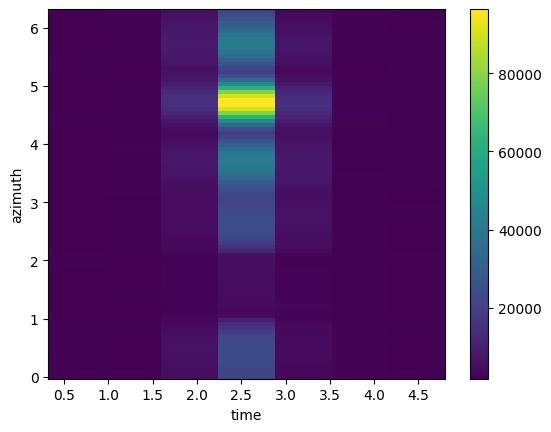

In [28]:
P.sum("speed").plot.imshow()